# 楽曲のコード進行を取得したい。

## Songleを用いたやり方  

https://songle.jp/ にはAPIが公開されている  
http://widget.songle.jp/docs/v1 を読むと、  
http://widget.songle.jp/api/v1/song/chord.json?url=www.youtube.com/watch?v=PqJNc9KVIZE  
のようにすればコード進行のjsonを取得できるようだ。

REST API なのでHTTPメソッドでアクセスすればよく、pythonからはrequestsでデータを取得可能。  
https://note.nkmk.me/python-requests-web-api/

In [1]:
import requests
import pandas as pd
import json
import numpy as np
import re

In [2]:
# 定数定義
HALF_TONE_IN_OCTAVE = 12

In [3]:
def get_chord_analysis(song_url):
    r_get = requests.get("http://widget.songle.jp/api/v1/song/chord.json?url=" + song_url)

    if (r_get.status_code != 200):
        print("ERROR! could not get the Songle API result.")
        print("status is "+ r_get.status_code)
        return None
    p = r_get.json()['chords'] 
    # キー'chords'に対応する値を取得する
    # type(p)はlist
    # type(json.dumps(p)) はstr リスト→文字列 後続のread_jsonの入力が文字列じゃなきゃいけないので
    # read_jsonの引数はURLでも良いので、
    # pd.read_json("http://widget.songle.jp/api/v1/song/chord.json?url=www.nicovideo.jp/watch/sm30067009")
    # でもコードのデータが取れるが、これだと少し違う結果になってしまうので、今回はこのまま行く
    chord_df = pd.read_json(json.dumps(p))
    return chord_df

In [4]:
song_url_bokura = "www.youtube.com/watch?v=LtSNzPyo0lA"
# ぼくらはみんな意味不明 ピノキオピー

df_bokura = get_chord_analysis(song_url_bokura)

# 作戦会議

「ある曲の「ある部分の」転調したときのコード構成が他の曲の「ある部分の」コード構成と類似している」ことが知りたい  

・曲の区間を選び出す 方法は?→ 繰り返し構造がアノテートされているから、そこを拾えば行けそうだ感がある  
・そこのコードの音程を分析する  
    ・パース 原音とコード名 / N  
    ・音程の導出  
    ・分数コード(MVP段階では捨てても良い)  
    
・テンポ  
　　・基準となる数値を見つける  
  　・それぞれのdurationを基準値で割ってクオンタイズ  
    ・同時に、BPMを推定

・転調 は総当たりで行けるだろう、音程変化に対応する操作を実装するのは楽

・コード構成の類似  durationが一致とは限らないので難しいが、基本的には構成音の共通がどれくらい多いかで見れば良さそう

# 作戦会議2

いや……一旦2曲の類似を確認するくらいならそんなに要らないんじゃないか?

・サビ同士を決め打ちで区間抽出して、決め打ちで転調して、コード構成の類似を見れば良い!

# やらないこと

- 音楽コード分析の精度を追求しない
- サビは16単位分の固定とする、長さを変えない
- 

In [5]:
# で、本当は1拍が何秒になるか計算しなきゃいけないけど、今は決め打ちすることにしてすっ飛ばす
# durationを1060で割ってみる
unit_ms = 1060
df_bokura["duration"] = (df_bokura["duration"]/ unit_ms).round().astype("int64")

In [6]:
key_to_half_tone = {
#         'Cb': 11, 
         'C': 0, 
         'C#': 1, 
         'Db': 1,
         'D' : 2,
         'D#': 3,
         'Eb': 3,
         'E' : 4,
#         'E#': 5,
#         'Fb': 4,
         'F' : 5,
         'F#': 6,
         'Gb': 6,
         'G' : 7,
         'G#': 8,
         'Ab': 8,
         'A' : 9,
         'A#': 10,
         'Bb': 10,
         'B' : 11,
#         'B#': 0,
        }

In [7]:
half_tone_to_key = {
#         'Cb': 11, 
         0: 'C', 
         1: 'C#', 
         2: 'D',
         3: 'Eb',
         4: 'E',
         5: 'F',
         6: 'F#',
         7: 'G',
         8: 'G#', #Abでも可
         9: 'A',
         10: 'Bb',
         11: 'B',
        }

In [8]:
chord_to_half_tone = {
    '' : [0, 4, 7],  #メジャー
    'm' : [0, 3, 7],
    'aug' : [0, 4, 8],
    'dim' : [0, 3, 6],
    '7' : [0, 4, 7, 10],
    'M7' : [0, 4, 7, 11],
    'm7' : [0, 3, 7, 10],
    '6' : [0, 4, 7, 9],
}

In [9]:
def chord_to_pitch(chord_name):
    # 文字列を受け取ると音の配列を返す
    # 0がC, 1がC#, ..., 11がB
    # chrod_nameが"N"ならばコードが無いので空配列
    if chord_name == "N":
        return np.array([], dtype='int32')
    # 一旦分数コードを考慮外にしたいので、 /以降を切り捨てる
    chord_name = re.search("^[^/]+", chord_name)
    # ^ 先頭、 ^/ スラッシュ以外、 + 一文字以上繰り返し
    # searchで返ってくるのはmatchオブジェクトなので、その中身をgroupで取得
    chord_name = chord_name.group()
    
    # キーと和音部分にパース
    if len(chord_name) > 1 and (chord_name[1] == "#" or chord_name[1] == "b"):
        key = chord_name[0:2]
        chord = chord_name[2:]
    else:
        key = chord_name[0]
        chord = chord_name[1:]
    
    #まずキーを数字に変換 ハッシュ(辞書)を使う
    key_num = key_to_half_tone[key]
    
    #次にコードを数字に変換 これもハッシュ(辞書)
    if chord not in chord_to_half_tone:
        print("ERROR! This chord is not registered: " + chord)
        return None
    
    chord_num = chord_to_half_tone[chord]

    return key_num + np.array(chord_num)

In [10]:
chord_to_pitch("E7")

array([ 4,  8, 11, 14])

In [11]:
# 約62.640秒から約17.200秒間のコードを判別する
# 62.640 - 79.840 秒
# index 30以上39以下
sabi_bokura = df_bokura.iloc[30:40]

## 前処理：「ぼくらはみんな意味不明」のコード修正 正しくコード取れていないので

In [12]:
sabi_bokura

,duration,index,name,start
30,2,30,N,62750
31,2,31,Abm,64878
32,2,32,N,67000
33,2,33,Abm7,69122
34,1,34,EM7,71250
35,1,35,B/F#,72306
36,2,36,Abm,73367
37,1,37,EM7,75494
38,1,38,F#,76550
39,2,39,Abm,77617


In [13]:
sabi_bokura.loc['30.1'] = [1, 30.1, 'E' , -1]
sabi_bokura.loc['30.2'] = [1, 30.2, 'F#' , -1]

sabi_bokura.loc['32.1'] = [1, 32.1, 'E' , -1]
sabi_bokura.loc['32.2'] = [1, 32.2, 'F#' , -1]

c:\program files\python37\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
c:\program files\python37\lib\site-packages\ipykernel_laun

In [14]:
sabi_bokura.sort_values('index',inplace=True)
rows_to_drop = sabi_bokura["index"][sabi_bokura["name"] == "N"]
sabi_bokura.drop(rows_to_drop, inplace=True)
type(rows_to_drop)
rows_to_drop

c:\program files\python37\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
c:\program files\python37\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


30    30.0
32    32.0
Name: index, dtype: float64

In [15]:
sabi_bokura

,duration,index,name,start
30.1,1,30.1,E,-1
30.2,1,30.2,F#,-1
31,2,31.0,Abm,64878
32.1,1,32.1,E,-1
32.2,1,32.2,F#,-1
33,2,33.0,Abm7,69122
34,1,34.0,EM7,71250
35,1,35.0,B/F#,72306
36,2,36.0,Abm,73367
37,1,37.0,EM7,75494


In [16]:
sabi_bokura["chord_pitch"] = sabi_bokura["name"].map(chord_to_pitch)

c:\program files\python37\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [17]:
sabi_bokura

,duration,index,name,start,chord_pitch
30.1,1,30.1,E,-1,"[4, 8, 11]"
30.2,1,30.2,F#,-1,"[6, 10, 13]"
31,2,31.0,Abm,64878,"[8, 11, 15]"
32.1,1,32.1,E,-1,"[4, 8, 11]"
32.2,1,32.2,F#,-1,"[6, 10, 13]"
33,2,33.0,Abm7,69122,"[8, 11, 15, 18]"
34,1,34.0,EM7,71250,"[4, 8, 11, 15]"
35,1,35.0,B/F#,72306,"[11, 15, 18]"
36,2,36.0,Abm,73367,"[8, 11, 15]"
37,1,37.0,EM7,75494,"[4, 8, 11, 15]"


# youtubeとニコニコ動画で解析結果が大きく異なる問題について
妄想感傷代償連盟  
youtube https://www.youtube.com/watch?v=8pGRdRhjX3o  
nico https://www.nicovideo.jp/watch/sm30067009  

再生画面  
https://songle.jp/songs/www.youtube.com%2Fwatch%3Fv=8pGRdRhjX3o  
https://songle.jp/songs/www.nicovideo.jp%2Fwatch%2Fsm30067009  
youtubeの方にはほとんどコードが入っていない

REST APIを叩いた結果は違うのか?→全然違う。 たぶん再生画面と一致している。

http://widget.songle.jp/api/v1/song/chord.json?url=www.youtube.com/watch?v=8pGRdRhjX3o  
→62個のコード

http://widget.songle.jp/api/v1/song/chord.json?url=www.nicovideo.jp/watch/sm30067009  
→150個のコード

原因は不明……  
明らかにyoutube版はコードの内容がおかしいので、ニコニコ動画の解析結果を元にして進める


In [18]:
song_url = "www.nicovideo.jp/watch/sm30067009"
# 妄想感傷代償連盟 DECO*27
df_mousou = get_chord_analysis(song_url)

In [19]:
# で、本当は1拍が何秒になるか計算しなきゃいけないけど、今は決め打ちすることにしてすっ飛ばす
# durationを1090で割ってみる
unit_ms_mousou = 1090 
df_mousou ["duration"] = (df_mousou ["duration"]/ unit_ms_mousou).round().astype("int64")

In [20]:
# 約61.120秒から約17.440秒間のコードを判別する
# 61.120 - 78.560 秒
# index 17以上30以下
sabi_mousou = df_mousou.iloc[17:31]

In [21]:
sabi_mousou["chord_pitch"] = sabi_mousou["name"].map(chord_to_pitch)

c:\program files\python37\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [22]:
sabi_mousou

,duration,index,name,start,chord_pitch
17,1,17,C#M7,61150,"[1, 5, 8, 12]"
18,1,18,C7,62239,"[0, 4, 7, 10]"
19,1,19,Fm7,63328,"[5, 8, 12, 15]"
20,1,20,Cm7,64417,"[0, 3, 7, 10]"
21,1,21,C#M7,65510,"[1, 5, 8, 12]"
22,1,22,C7,66600,"[0, 4, 7, 10]"
23,2,23,F,67689,"[5, 9, 12]"
24,1,24,C#M7,69872,"[1, 5, 8, 12]"
25,1,25,C7,70967,"[0, 4, 7, 10]"
26,1,26,Fm,72056,"[5, 8, 12]"


## 転調のシミュレーション

In [23]:
# 「ぼくらはみんな意味不明」を移調したときのコード ≒ 「妄想感傷代償連盟」を移調したときのコード
# 「ぼくらはみんな意味不明」 最初の「よ」 で原曲G#→マッシュアップG なので半音1つ下に移調
# 「妄想感傷代償連盟」 歌詞最初の伴奏部のうち高い方の音 F→G なので半音2つ上に移調

sabi_bokura["chord_pitch"] - 1

30.1         [3, 7, 10]
30.2         [5, 9, 12]
31          [7, 10, 14]
32.1         [3, 7, 10]
32.2         [5, 9, 12]
33      [7, 10, 14, 17]
34       [3, 7, 10, 14]
35         [10, 14, 17]
36          [7, 10, 14]
37       [3, 7, 10, 14]
38           [5, 9, 12]
39          [7, 10, 14]
Name: chord_pitch, dtype: object

In [24]:
sabi_mousou["chord_pitch"] + 2

17     [3, 7, 10, 14]
18      [2, 6, 9, 12]
19    [7, 10, 14, 17]
20      [2, 5, 9, 12]
21     [3, 7, 10, 14]
22      [2, 6, 9, 12]
23        [7, 11, 14]
24     [3, 7, 10, 14]
25      [2, 6, 9, 12]
26        [7, 10, 14]
27       [10, 14, 17]
28         [3, 7, 10]
29      [2, 6, 9, 12]
30        [7, 11, 14]
Name: chord_pitch, dtype: object

まぁ、何となく似ているのは分かるけど……  
どこがどのくらい一致してるのか分からないのが惜しい
音の長さの情報が消えちゃってるから、そこも入れて検討しなきゃ

- ビジュアルで示す クロマグラフっぽく。どこに音があるかを線などで示す  
- 音楽コードに直す →できた。 
- 1拍ごとに分解して、曲/ 曲/ 共通音の形で書く?



## 移調時の音楽コードを求める

In [25]:
def transpose(chord_name, pitch):
    # 文字列と移調幅を受け取り、文字列を返す
    # chrod_nameが"N"ならばコードが無いのでNを返す
    if chord_name == "N":
        return "N"
    # 一旦分数コードを考慮外にしたいので、 /以降を切り捨てる
    chord_name = re.search("^[^/]+", chord_name)
    # ^ 先頭、 ^/ スラッシュ以外、 + 一文字以上繰り返し
    # searchで返ってくるのはmatchオブジェクトなので、その中身をgroupで取得
    chord_name = chord_name.group()
    
    # キーと和音部分にパース and句の左側は"E"とかでchord_name[1]がなくてエラーになるのを防ぐため
    if len(chord_name) > 1 and (chord_name[1] == "#" or chord_name[1] == "b"):
        key = chord_name[0:2]
        chord = chord_name[2:]
    else:
        key = chord_name[0]
        chord = chord_name[1:]
    
    #まずキーを数字に変換 ハッシュ(辞書)を使う
    key_num = key_to_half_tone[key]
    
    #次にキーを移調する 
    transposed_key_num = (key_num + pitch) % HALF_TONE_IN_OCTAVE
     
    #数字からキーに戻す 黒鍵は#を使うかbを使うかがあるが、今は個人的な好みで決める
    transposed_key = half_tone_to_key[transposed_key_num]
    
    return transposed_key + chord

In [26]:
sabi_mousou["name_trans"] = sabi_mousou["name"].apply(transpose, args=(2,))
# argsに入れられるのはtupleだけなので、(1,)として要素一個のtupleを作ること (1)だとただのintになる
# map関数を通じて関数に引数を渡せないので、ここはmapは使えない
# apply関数のヘルプ https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.apply.html

c:\program files\python37\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [27]:
sabi_bokura["name_trans"] = sabi_bokura["name"].apply(transpose, args=(-1,))

c:\program files\python37\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [28]:
sabi_mousou, sabi_bokura

(    duration  index   name  start     chord_pitch name_trans
 17         1     17   C#M7  61150   [1, 5, 8, 12]       EbM7
 18         1     18     C7  62239   [0, 4, 7, 10]         D7
 19         1     19    Fm7  63328  [5, 8, 12, 15]        Gm7
 20         1     20    Cm7  64417   [0, 3, 7, 10]        Dm7
 21         1     21   C#M7  65510   [1, 5, 8, 12]       EbM7
 22         1     22     C7  66600   [0, 4, 7, 10]         D7
 23         2     23      F  67689      [5, 9, 12]          G
 24         1     24   C#M7  69872   [1, 5, 8, 12]       EbM7
 25         1     25     C7  70967   [0, 4, 7, 10]         D7
 26         1     26     Fm  72056      [5, 8, 12]         Gm
 27         1     27   Ab/C  73150     [8, 12, 15]         Bb
 28         1     28  C#/G#  74239       [1, 5, 8]         Eb
 29         1     29     C7  75328   [0, 4, 7, 10]         D7
 30         2     30      F  76417      [5, 9, 12]          G,
       duration  index  name  start      chord_pitch name_trans
 30.1

In [29]:
def transpose_pitch(half_tone, pitch):
    # 配列と移調幅を受け取り、配列を返す
    # 空配列ならばコードが無いので、空配列を返す
    #if half_tone == []:
    #    return []
    return np.sort((half_tone + pitch) % HALF_TONE_IN_OCTAVE)

In [30]:
t1 = np.array([0,4,7])
transpose_pitch(t1, 6)


array([ 1,  6, 10], dtype=int32)

In [31]:
sabi_mousou["pitch_trans"] = sabi_mousou["chord_pitch"].apply(transpose_pitch, args=(2,))
sabi_bokura["pitch_trans"] = sabi_bokura["chord_pitch"].apply(transpose_pitch, args=(-1,))


c:\program files\python37\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [32]:
sabi_mousou, sabi_bokura

(    duration  index   name  start     chord_pitch name_trans    pitch_trans
 17         1     17   C#M7  61150   [1, 5, 8, 12]       EbM7  [2, 3, 7, 10]
 18         1     18     C7  62239   [0, 4, 7, 10]         D7   [0, 2, 6, 9]
 19         1     19    Fm7  63328  [5, 8, 12, 15]        Gm7  [2, 5, 7, 10]
 20         1     20    Cm7  64417   [0, 3, 7, 10]        Dm7   [0, 2, 5, 9]
 21         1     21   C#M7  65510   [1, 5, 8, 12]       EbM7  [2, 3, 7, 10]
 22         1     22     C7  66600   [0, 4, 7, 10]         D7   [0, 2, 6, 9]
 23         2     23      F  67689      [5, 9, 12]          G     [2, 7, 11]
 24         1     24   C#M7  69872   [1, 5, 8, 12]       EbM7  [2, 3, 7, 10]
 25         1     25     C7  70967   [0, 4, 7, 10]         D7   [0, 2, 6, 9]
 26         1     26     Fm  72056      [5, 8, 12]         Gm     [2, 7, 10]
 27         1     27   Ab/C  73150     [8, 12, 15]         Bb     [2, 5, 10]
 28         1     28  C#/G#  74239       [1, 5, 8]         Eb     [3, 7, 10]

In [33]:
from PIL import Image, ImageDraw

im = Image.new('RGB', (500, 300), (128, 128, 128))
draw = ImageDraw.Draw(im)

In [34]:
im.show()

(-0.5, 499.5, 299.5, -0.5)

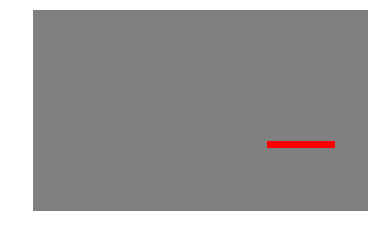

In [35]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

plt.imshow(im)
plt.axis("off")

# 赤い横線
draw.line((350, 200, 450, 200), fill=(255, 0, 0), width=10)
# 実線のみ。点線とかは描けない

plt.imshow(im)
plt.axis("off")

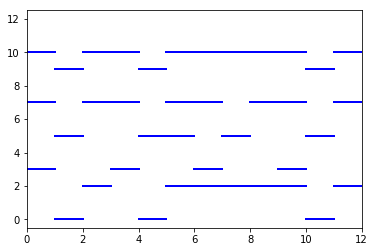

In [36]:
beat = 0
for chord in sabi_bokura["pitch_trans"]: ##★ここを後で可変にする
    for i in chord:
        plt.plot([beat, beat+1], [i, i], "b-", linewidth=2)
        # 音程の正則化（12で割った剰余）は必要ある？ない？
    beat += 1

    # x軸描画範囲は特に希望無いけど、x軸y軸のどっちも指定しないといけないので区間ギリギリを指定
    # y軸描画範囲を0～11 + 余白にする（余白がないと0や11の位置の線が見づらい）
    VERTICAL_MERGIN = 0.5
    plt.axis([0, beat, -VERTICAL_MERGIN, HALF_TONE_IN_OCTAVE-1+VERTICAL_MERGIN])